# Learning a Directed Acyclic Graph (DAG) on data.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_dag_learning.ipynb)


This tutorial considers the problem of learning a Directed Acyclic Graph (DAG) on data. This is a common problem in causal inference, where we are interested in learning the dependency relationships between variables. In this notebook, we will demonstrate how to learn a DAG on data using a {py:class}`~cooper.formulations.QuadraticPenalty` formulation in **Cooper**.

In [10]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

In [11]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch

import cooper

## Problem Formulation

Consider a $d$-dimensional random vector ${X_1, X_2, ..., X_d}$. Given $n$ observations of the random vector $X \in \mathbb{R}^{n \times d}$, we are interested in learning a DAG $G = (V, E)$ whose edges represent the dependencies between the variables. We model the DAG via an adjacency matrix $A \in \{0, 1\}^{d \times d}$, where $A_{ij} = 1$ if there is an edge from $X_i$ to $X_j$ and $A_{ij} = 0$ otherwise.

This problem can be formulated as the following optimization problem:

$$
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + r \|A\|_1,
\quad \text{s.t.} \quad A \text{ is acyclic},
$$

where $\| \cdot \|_F$ is the Frobenius norm, $r$ is a regularization parameter aimed at encougaing sparsity in the learned DAG, and the constraint ensures that the learned graph is acyclic.

{cite:t}`NOTEARS` show that the acyclicity constraint can be formulated as $\text{tr}(e^{A}) = d$, where $e^{A}$ is the matrix exponential of $A$. This yields the following optimization problem:

$$
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + r \|A\|_1,
\quad \text{s.t.} \quad \text{tr}(e^{A}) = d.
$$

## Data Generation

The generative process we use is:

$X_i \leftarrow \sum_{j \in \pi_i} X_j + \epsilon_i$

where $\pi_i$ is the set of parents of $X_i$, and $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise.

In [12]:
torch.manual_seed(1)
np.random.seed(1)


def generate_data(n: int, d: int, n_causes: int, noise_std: float, device: torch.device):
    """Generate data from a linear structural equation model with Gaussian noise.
    The

    Args:
        n: number of samples
        d: number of features
        n_causes: number of roots in the graph
        noise_std: standard deviation of the noise
        device: torch.device

    Returns:
        torch.Tensor: Data (X) of shape (n, d)
        torch.Tensor: Graph (A) of shape (d, d)
    """
    assert n_causes <= d

    # --------------------------------------------
    # Generate the adjacency matrix
    # --------------------------------------------

    # Rows are nodes, columns are parents
    A = torch.zeros(d, d, device=device)

    for i in range(n_causes, d):
        # For i=1, the only possible parent is 0
        parents = 0 if i == 1 else torch.randperm(i)[: np.random.randint(1, i)]

        A[i, parents] = 1

    assert torch.trace(torch.linalg.matrix_exp(A)).item() == d, "A is not a DAG"

    # --------------------------------------------
    # Sample data
    # --------------------------------------------

    noise = noise_std * torch.randn(n, d, device=device)
    X = torch.zeros(n, d, device=device)

    for i in range(d):
        parents = torch.nonzero(A[i]).flatten()
        X[:, i] = X[:, parents].sum(dim=1) + noise[:, i]

    # Improve conditioning
    X /= math.sqrt(d)

    return X, A

Now we generate the data and visualize the underlying DAG.

In [13]:
D = 5
N = 5_000
N_CAUSES = 1
NOISE_STD = 1e-2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate data
X, A_TRUE = generate_data(N, D, N_CAUSES, NOISE_STD, DEVICE)

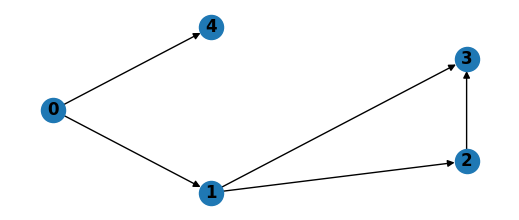

In [31]:
# Visualize the graph
G = nx.DiGraph()

G.add_nodes_from(range(D))
for i in range(D):
    for j in range(D):
        if A_TRUE[i, j] != 0:
            G.add_edge(j, i)

pos = nx.shell_layout(G)

plt.figure(figsize=(5, 2))
nx.draw(G, pos, with_labels=True, font_weight="bold")
plt.show()

## Solving the Problem

We will use the {py:class}`~cooper.formulations.QuadraticPenalty` formulation to solve the problem. This leads to the following formulation of the constrained optimization problem:

$$
\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2 + r \|A\|_1 + \frac{c}{2}[\text{tr}(e^{A}) - d]^2,
$$

where $c$ is a penalty parameter. We will use a {py:class}`cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater` to increase the penalty coefficient $c$ whenever the constraint is violated beyond a tolerance.

### ConstrainedMinimizationProblem

In [15]:
class DAGLearning(cooper.ConstrainedMinimizationProblem):
    def __init__(self, X: torch.Tensor, r: float):
        super().__init__()

        self.X = X
        self.n, self.d = X.shape
        self.r = r

        penalty_coefficient = cooper.penalty_coefficients.DensePenaltyCoefficient(
            init=torch.tensor(1.0, device=X.device),
        )
        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=cooper.formulations.QuadraticPenalty,
            penalty_coefficient=penalty_coefficient,
        )

    def compute_cmp_state(self, A: torch.Tensor) -> cooper.CMPState:
        loss = torch.linalg.norm(self.X - self.X @ A.T, ord="fro") ** 2
        loss += self.r * torch.linalg.norm(A, ord=1)

        constraint_value = torch.trace(torch.linalg.matrix_exp(A)) - self.d
        constraint_state = cooper.ConstraintState(violation=constraint_value)

        return cooper.CMPState(loss=loss, observed_constraints={self.constraint: constraint_state})

### Training

In [16]:
A = torch.nn.Parameter(torch.randn(D, D, device=DEVICE) / math.sqrt(D))

R = 1e-3
PRIMAL_LR = 1e-2
MOMENTUM = 0.9
N_STEPS = 2_000

cmp = DAGLearning(X, R)

primal_optimizer = torch.optim.SGD([A], lr=PRIMAL_LR, momentum=MOMENTUM)
constrained_optimizer = cooper.optim.UnconstrainedOptimizer(cmp=cmp, primal_optimizers=primal_optimizer)

# Multiply the penalty coefficient by `growth_factor` if the constraint is violated
# by more than `violation_tolerance`
penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
    increment=1.0,
    violation_tolerance=1e-4,
)


steps, losses, violations, penalty_coefficients = [], [], [], []  # for plotting
for i in range(N_STEPS):
    roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs={"A": A})

    A.data.fill_diagonal_(0)  # set the diagonal to zero to prevent self-loops
    A.data.clamp_(min=0, max=1)  # ensure that A is a valid adjacency matrix

    # Update the penalty coefficient
    constraint_state = roll_out.cmp_state.observed_constraints[cmp.constraint]
    penalty_scheduler.update_penalty_coefficient_(cmp.constraint, constraint_state)

    loss = roll_out.loss.item()
    violation = constraint_state.violation.item()
    primal_lagrangian = roll_out.primal_lagrangian_store.lagrangian.item()
    penalty_coefficient_value = cmp.constraint.penalty_coefficient().item()

    if i % (N_STEPS // 100) == 0:
        steps.append(i)
        losses.append(loss)
        violations.append(violation)
        penalty_coefficients.append(penalty_coefficient_value)

### Results

In [17]:
def plot_adjacency(adjacency, gt_adjacency):
    """Plot side by side: 1)the learned adjacency matrix, 2)the ground truth adj
    matrix and 3)the difference of these matrices
    :param np.ndarray adjacency: learned adjacency matrix
    :param np.ndarray gt_adjacency: ground truth adjacency matrix
    :param str exp_path: path where to save the image
    :param str name: additional suffix to add to the image name
    """
    plt.clf()
    _, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)

    kwargs = {"vmin": 0, "vmax": 1, "cmap": "Blues", "xticklabels": False, "yticklabels": False}
    sns.heatmap(adjacency, ax=ax2, cbar=False, **kwargs)
    sns.heatmap(gt_adjacency, ax=ax3, cbar=False, **kwargs)
    sns.heatmap(adjacency - gt_adjacency, ax=ax1, cbar=False, **kwargs)

    ax1.set_title("Difference (Learned, GT)")
    ax2.set_title("Learned")
    ax3.set_title("Ground truth")

    ax1.set_aspect("equal", adjustable="box")
    ax2.set_aspect("equal", adjustable="box")
    ax3.set_aspect("equal", adjustable="box")

    plt.show()


def plot_progress(steps, losses, penalty_coefficients):
    _, ax1 = plt.subplots(figsize=(5, 3))
    ax2 = ax1.twinx()
    ax1.plot(steps, losses, "tab:blue")
    ax2.plot(steps, penalty_coefficients, "tab:red")

    ax1.set_yscale("log")

    ax1.set_xlabel("Steps", fontsize=12)
    ax1.set_ylabel("Loss", color="tab:blue", labelpad=10, fontsize=16)
    ax2.set_ylabel("Penalty coefficient", color="tab:red", labelpad=10, fontsize=16)

    plt.show()

## Results

The following plot shows the loss and penalty coefficient as a function of the number of iterations. We can observe the following:

* The loss decreases over time and eventually plateaus, as expected due to the noisy data generation process.
* The penalty coefficient increases throughout training to enforce the acyclicity constraint. This increase is more pronounced early on because the initial DAG is not acyclic. Later, as the loss-driven updates to the DAG lead to constraint violations, the penalty coefficient continues to rise.

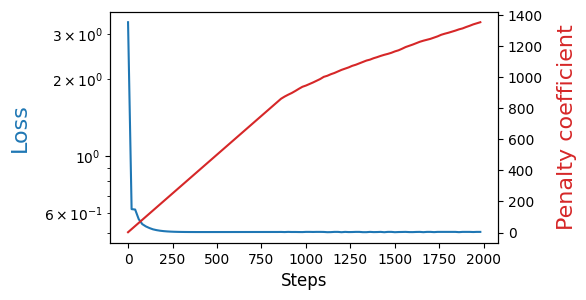

In [18]:
plot_progress(steps, losses, penalty_coefficients)

The next plot shows the adjacency matrix of the learned DAG, compared to the ground truth DAG. We can observe that we are able to recover the true DAG structure.

<Figure size 640x480 with 0 Axes>

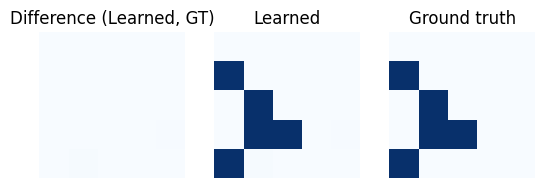

In [19]:
plot_adjacency(A.cpu().detach().numpy(), A_TRUE.cpu().detach().numpy())